# Tree based methods

In [1]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np

import optuna
from imblearn.over_sampling import SMOTE

from utils import import_and_transform
from utils import get_churned_users
from utils import aggregate_features_improved, aggregate_features_improved2
from utils import evaluate_model

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier


## Import data and apply transformations

### Train data

In [2]:
df_train = import_and_transform("Data/train.parquet")

In [3]:
user_data = import_and_transform(df_train)

In [4]:
user_data.head(1)

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,...,itemInSession,userAgent,method,length,song,artist,time,registration,session_length,song_played
0,200,NaN,Shlok,NaN,Johnson,1749042,2018-10-01 00:00:01,Logged In,NextSong,22683,...,278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21,11405.0,1


### Test data

In [5]:
df_test = import_and_transform("Data/test.parquet")

In [6]:
test_data = import_and_transform(df_test)

In [7]:
test_data.head(1)


,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,...,itemInSession,userAgent,method,length,song,artist,time,registration,session_length,song_played
7,200,NaN,Jonathan,NaN,Martin,1465194,2018-10-01 00:00:06,Logged In,NextSong,22483,...,29,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,250.8273,Mockingbird,Eminem,2018-10-01 00:00:06,2018-09-27 17:29:36,46790.0,1


## Aggregate data

Based on the exploratory data analysis **EDA**, we will now modify our database accordingly. The EDA showed issues and necessary changed that require database modifications.

We want to capture more temporal patterns. We want to "teach" the model to recognize churn patterns across different time periods. How do we do that?

If we look at only one point in the time, we do not have enough examples to train the model. So instead of taking just one "snapshot", we take multiple snapshots at different times and we consider each one of them as individual prediction problems. 

Like this, we increase our training data.

In [8]:
# Createing observation dates every 5 days
# Create multiple training samples with sliding window
training_dates = pd.date_range("2018-10-15", "2018-11-05", freq="5D")

X_train_list = []
y_train_list = []

# For each observ date, we create a separate training sample:
for obs_date in training_dates:
    # Filtering data up to the observation date
    df_obs = df_train[df_train["ts"] <= obs_date]
    # features = aggregate_features_improved(df_obs, obs_date)   # Better aggregate function.
    features = aggregate_features_improved2(df_obs, obs_date)  # Better function, but takes ages to run
    
    # Creating a 10 day window after the obervation date
    # And we identify who churned in that period
    window_end = obs_date + pd.Timedelta(days=10)
    churned_users = get_churned_users(df_train, obs_date, window_end)

    # 1 if they churned in the next 10 days, 0 otherwise
    labels = pd.Series(
        features.index.isin(churned_users).astype(int),
        index=features.index,
        name="churned",
    )

    X_train_list.append(features)
    y_train_list.append(labels)

    print(
        f"Date of the observation: {obs_date.date()}, with {len(features)} users, and a {labels.mean():.2%} churn rate"
    )

# We combine all observation windows:
X_train_combined = pd.concat(X_train_list)
y_train_combined = pd.concat(y_train_list)

# Drop non-numeric columns
feature_cols = X_train_combined.select_dtypes(include=[np.number]).columns
feature_cols = [
    c
    for c in feature_cols
    if c not in ["registration", "ts_min", "ts_max", "total_length"]
]

X_train_final = X_train_combined[feature_cols]

Date of the observation: 2018-10-15, with 16271 users, and a 5.08% churn rate
Date of the observation: 2018-10-20, with 17347 users, and a 4.48% churn rate
Date of the observation: 2018-10-25, with 17888 users, and a 4.49% churn rate
Date of the observation: 2018-10-30, with 18271 users, and a 4.46% churn rate
Date of the observation: 2018-11-04, with 18592 users, and a 3.78% churn rate


Let's split our data in 80% train and 20% test.

In [28]:
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train_combined)

X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, 
                                                    test_size=0.20, random_state=42)

We apply the same transformations to our test file.

In [10]:
test_features = aggregate_features_improved2(df_test, "2018-11-20")
test_submission = test_features[feature_cols]

C:\Users\Martin\Documents\X HEC\Python for Data Science\Project\utils.py:529: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  user_df = user_df.fillna(0)


Let's have a look at our data now. Does it look as we want it?

In [11]:
X_train_final.head(1)

,gender,level_first,level_current,num_sessions,avg_session_length,num_songs_played,unique_artists,unique_songs,avg_song_length,days_active,...,weighted_sessions,last_session_length,has_social_activity,positive_actions,satisfaction_ratio,engagement_rate,problem_signals,ads_per_song,actions_per_session,churn_risk_score
userId,,,,,,,,,,,,,,,,,,,,,
1000025,1,0,1,11,56774.847498,1030,795,935,249.797113,12,...,4.409754,19928.0,1,121.0,0.864198,0.131911,0.0,0.00388,104.916667,2


We observe that we have our rates (very important features for our training) and everything looks as we wanted. We can now continue the project by testing different models.

## Testing out different models

### Logistic Regression

We are trying to predict 0/1 Yes/No churn. The very first intuitive step to do is to apply Logistic Regression and then optimize it.

Hence, we start by applying a vanilla Logistic Regression model.

In [12]:
log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6514698481304952

Confusion Matrix:
 [[11715  5018]
 [ 6755 10291]]

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.70      0.67     16733
           1       0.67      0.60      0.64     17046

    accuracy                           0.65     33779
   macro avg       0.65      0.65      0.65     33779
weighted avg       0.65      0.65      0.65     33779



C:\Users\Martin\Documents\X HEC\env\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Later, we will perform hyperparameter tuning. For this, we need to note the following ideas:

In Logistic Regression, we have hyperprameters that we need to choose *before* the training so we control how the model learns. Our hyperparameters are:

- **C**: how much we penalize complexity (too high is overfitting, too low is underfitting)
- **penalty**: which type of regularization we use (l1 or l2)
- **solver**: which optimization algorithm we use

Since we do not know which combination of these 3 is the best, we need to try all of them to decide which one we'll use in the end.

For solver, we use "Liblinear", and "Saga". A solver is an optimization algorithm that finds the best model param during training. **Saga** is fast, uses low memory and is built for big data. Moreover, it uses Stochastic Average Gradient descent, meaning it updates the model parameters using small bacthes of data at time, it does not load the whole dataset in memory from the beginning, and it converges fast on big data. **Liblinear** is more reliable and is a classic choice.

**ROC-AUC** (area under the curve) measures how well the model separates the 2 classes, despite the imbalance. So in our case, it is used to answer:

"What is the probability the model will rank the churner higher if we pick one churner and one non-churner at random?"

Possible scores:

- $<0.5$ means wrose than random
- $~0.5$ means random guessing
- $1.0$ means perfect

In [13]:
# We define the param grid
param_grid = {
    "C": [0.01, 1, 5, 50], # Regularization strength
    "penalty": ["l1", "l2"], # l1 = Lasso, l2 = Ridge
    "solver": ["liblinear", "saga"], # Optim algorithm
    "class_weight": ["balanced"], # Handle class imbalance
    "max_iter": [1000]
}

# We use cross-validation, because our dataset is imbalanced
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# We perform grid search over all the combinations
# We optimize for ROC-AUC
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

# We train on all the combinations of parameters
grid_search.fit(X_train_final, y_train_combined)

print()
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")

# Let's save the best model now:
best_model = grid_search.best_estimator_

NameError: name 'GridSearchCV' is not defined

We found the best parameters and we will use them to evaluate on the test set.

We got the best ROC-AUC score of 70%, which means that the model learned some real churn patters. However, 30% will miss some churners. The ideal ROC-AUC score for churn prediction should be around 85%.

Now that we have the best model, let's evaluate it on our test set:

In [ ]:
evaluate_model(log_reg, test_submission, file_out="submission-log_reg.csv")

### Decision Tree Classifier

The next logical idea would be to try a tree based classifier, as they are known having one of the best performances for a lot of classification tasks, which includes a lot of Kaggle challenges. Similar to logstic regression, we have different hyperparameters that we can train for these models.

In [14]:
clf_dt = DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42)
clf_dt.fit(X_train, y_train)

y_pred = clf_dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.895319577252139

Confusion Matrix:
 [[15823   910]
 [ 2626 14420]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90     16733
           1       0.94      0.85      0.89     17046

    accuracy                           0.90     33779
   macro avg       0.90      0.90      0.90     33779
weighted avg       0.90      0.90      0.90     33779



In [15]:
evaluate_model(clf_dt, test_submission, file_out="submission-dt.csv")

Base predicted churn: 16.43%
Submission saved to submission-dt.csv


To get an idea of which features are most important for the decision tree model, it's also helpful to display the decision tree in a plot to see on which features does the model perform a split at first. For trees with a large maximum depth, the lower leaves becomes quite unclear to see, but at least we are able to see the first 2-3 levels to see which are the most important splits.


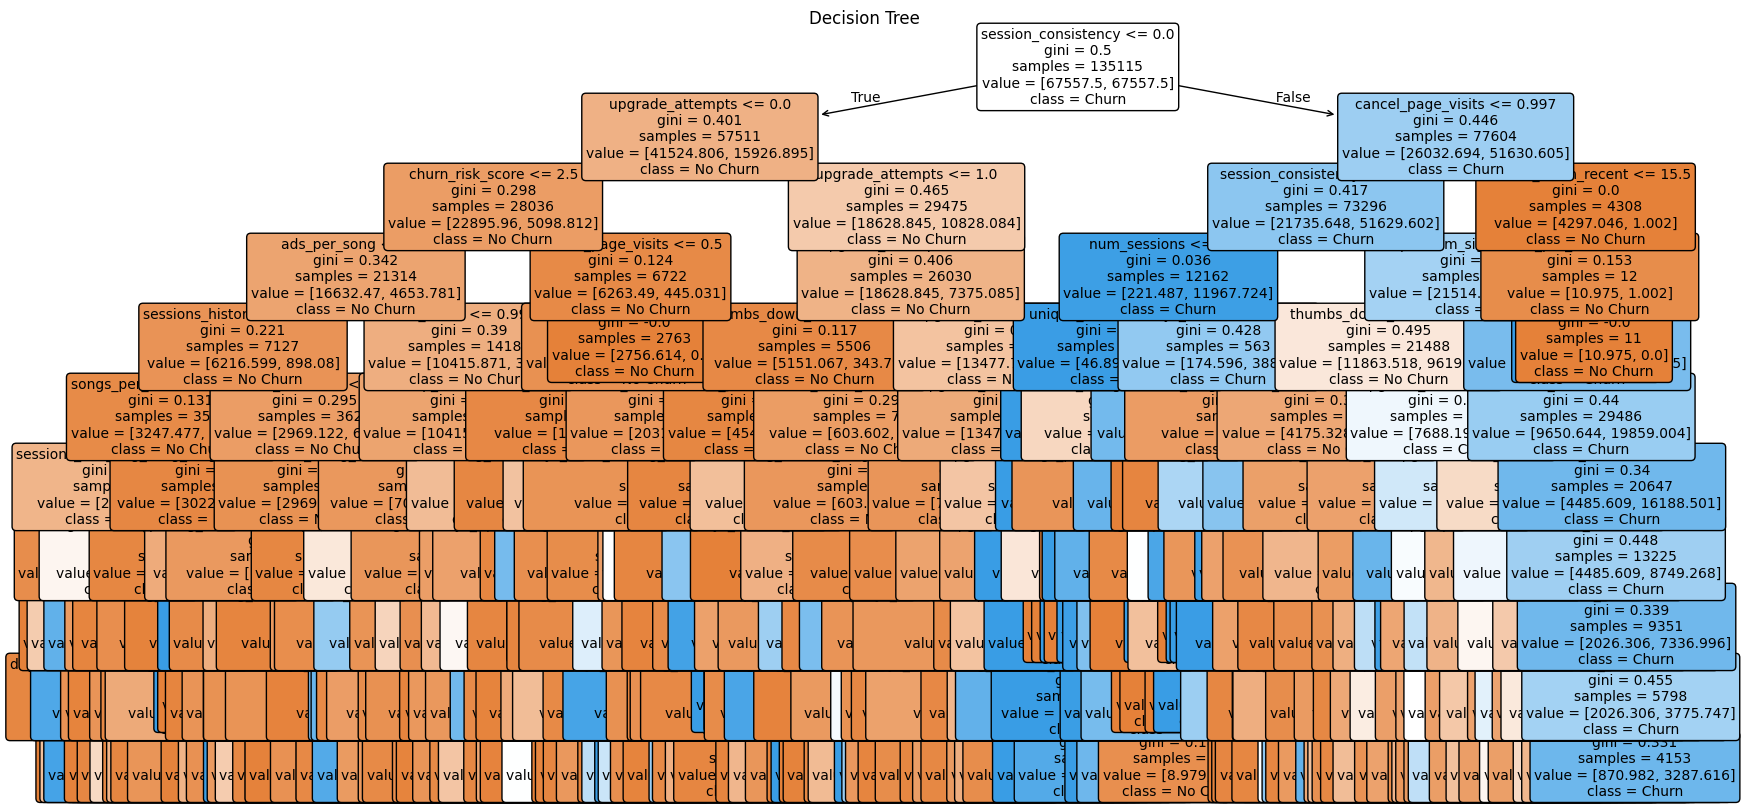

In [16]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    clf_dt,
    feature_names=X_train.columns,
    class_names=["No Churn", "Churn"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree")
plt.show()

### XGBoost

In [17]:
import xgboost as xgb
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_ratio = neg / pos

clf_xgb = xgb.XGBClassifier(
    scale_pos_weight=scale_ratio,  # handles imbalance
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

clf_xgb.fit(X_train, y_train)

y_pred = clf_xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


C:\Users\Martin\Documents\X HEC\env\lib\site-packages\xgboost\training.py:199: UserWarning: [10:19:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9634684271292815
Confusion Matrix:
 [[16596   137]
 [ 1097 15949]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     16733
           1       0.99      0.94      0.96     17046

    accuracy                           0.96     33779
   macro avg       0.96      0.96      0.96     33779
weighted avg       0.96      0.96      0.96     33779

F1 Score: 0.9627550404442835


In [18]:
evaluate_model(clf_xgb, test_submission, file_out='submission-xgb.csv')

Base predicted churn: 1.38%
Submission saved to submission-xgb.csv


### RandomForest

In [19]:
clf_rf = RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)

# 6. Evaluate
y_pred = clf_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9145030936380592

Confusion Matrix:
 [[15001  1732]
 [ 1156 15890]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91     16733
           1       0.90      0.93      0.92     17046

    accuracy                           0.91     33779
   macro avg       0.92      0.91      0.91     33779
weighted avg       0.91      0.91      0.91     33779



In [20]:
evaluate_model(model=clf_rf, test_set=test_submission, p=0.47, file_out='submission-rf-047.csv')

Base predicted churn: 15.29%
Predicted churn at 0.47 threshold: 20.25%
Submission saved to submission-rf-047.csv


### CatBoost

In [21]:
scale_pos_weight = (y_train_combined == 0).sum() / (y_train_combined == 1).sum()

cat_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=50,
    scale_pos_weight=scale_pos_weight
)
cat_model.fit(X_train, y_train)

# Evaluate on original test set
y_pred = cat_model.predict(X_test)
y_proba = cat_model.predict_proba(X_test)[:, 1]

print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



0:	learn: 0.9554315	total: 182ms	remaining: 1m 30s
50:	learn: 0.9618125	total: 1.74s	remaining: 15.3s
100:	learn: 0.9647575	total: 3.32s	remaining: 13.1s
150:	learn: 0.9677795	total: 4.9s	remaining: 11.3s
200:	learn: 0.9704623	total: 6.45s	remaining: 9.6s
250:	learn: 0.9723756	total: 8.06s	remaining: 8s
300:	learn: 0.9740604	total: 9.59s	remaining: 6.34s
350:	learn: 0.9751986	total: 11.3s	remaining: 4.78s
400:	learn: 0.9764503	total: 13.4s	remaining: 3.3s
450:	learn: 0.9774803	total: 15.4s	remaining: 1.67s
499:	learn: 0.9785845	total: 16.9s	remaining: 0us
F1 Score: 0.8251451431916866
ROC-AUC: 0.9874605301102246

Confusion Matrix:
 [[ 9698  7035]
 [  133 16913]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.58      0.73     16733
           1       0.71      0.99      0.83     17046

    accuracy                           0.79     33779
   macro avg       0.85      0.79      0.78     33779
weighted avg       0.85      0.79

In [22]:
evaluate_model(model=cat_model, test_set=test_submission, p=0.45, file_out='submission-catb.csv')

Base predicted churn: 44.73%
Predicted churn at 0.45 threshold: 50.69%
Submission saved to submission-catb.csv


## Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from catboost import CatBoostClassifier
import numpy as np

# Calculate scale_pos_weight
scale_pos_weight = (y_train_combined == 0).sum() / (y_train_combined == 1).sum()

# Base CatBoost model
base_cat = CatBoostClassifier(
    random_seed=42,
    verbose=0,  # Suppress output during grid search
    scale_pos_weight=scale_pos_weight
)

# Parameter grid
param_grid = {
    'iterations': [200, 300, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128],
    'subsample': [0.7, 0.8, 0.9]
}

# Stratified K-Fold for imbalanced data
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid Search
print("Starting GridSearchCV...")
print(f"Total combinations: {np.prod([len(v) for v in param_grid.values()])}")
print("This may take a while...\n")

grid_search = GridSearchCV(
    estimator=base_cat,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',  # or 'roc_auc' if you prefer
    n_jobs=-1,  # Use all cores
    verbose=2
)

grid_search.fit(X_train_final, y_train_combined)

# Results
print("\n" + "="*50)
print("Best parameters:")
print(grid_search.best_params_)
print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
print("\n" + "="*50)
print("Training final model with best parameters...")
best_cat_model = CatBoostClassifier(
    **grid_search.best_params_,
    random_seed=42,
    verbose=50,
    scale_pos_weight=scale_pos_weight
)

best_cat_model.fit(X_train_final, y_train_combined)

# Predictions
cat_predictions = best_cat_model.predict(X_test)
cat_proba = best_cat_model.predict_proba(X_test)[:, 1]

print(f"\nPredicted churn rate: {cat_predictions.mean():.2%}")

# Save submission
submission = pd.DataFrame({
    'userId': test_features.index,
    'prediction': cat_predictions
})
submission.to_csv('submission_catboost_tuned.csv', index=False)
print("Submission saved: submission_catboost_tuned.csv")

# Save best parameters for future reference
import json
with open('best_catboost_params.json', 'w') as f:
    json.dump(grid_search.best_params_, f, indent=2)
print("Best parameters saved: best_catboost_params.json")

In [30]:
def objective_logistic_regression(trial, X_train, y_train):
    params = {
        'C': trial.suggest_float('C', 1e-4, 1e2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        'solver': trial.suggest_categorical('solver', ['saga']),  # saga supports all penalties
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }
    
    # l1_ratio only for elasticnet
    if params['penalty'] == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)
    
    model = LogisticRegression(**params, random_state=42, n_jobs=-1)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    
    return score


def objective_decision_tree(trial, X_train, y_train):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }
    
    model = DecisionTreeClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    
    return score


def objective_random_forest(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }
    
    if params['bootstrap']:
        params['max_samples'] = trial.suggest_float('max_samples', 0.5, 1.0)
    
    model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    
    return score


def objective_xgboost(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart'])
    }
    
    if params['booster'] == 'dart':
        params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        params['rate_drop'] = trial.suggest_float('rate_drop', 0.0, 0.5)
    
    model = xgb.XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric='logloss')
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    
    return score


def objective_catboost(trial, X_train, y_train):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 10)
    }
    
    model = CatBoostClassifier(**params, random_state=42, verbose=0)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    
    return score


def tune_all_models(X_train, y_train, n_trials=100):
    """
    Tune all models and return best parameters and scores.
    """
    results = {}
    
    models_config = {
        # 'Logistic Regression': objective_logistic_regression,
        # 'Decision Tree': objective_decision_tree,
        # 'Random Forest': objective_random_forest,
        # 'XGBoost': objective_xgboost,
        'CatBoost': objective_catboost
    }
    
    for model_name, objective_func in models_config.items():
        print(f"\n{'='*60}")
        print(f"Tuning {model_name}...")
        print(f"{'='*60}")
        
        study = optuna.create_study(
            direction='maximize',
            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
        )
        
        study.optimize(
            lambda trial: objective_func(trial, X_train, y_train),
            n_trials=n_trials,
            show_progress_bar=True
        )
        
        results[model_name] = {
            'best_params': study.best_params,
            'best_score': study.best_value,
            'study': study
        }
        
        print(f"\nBest {model_name} score: {study.best_value:.4f}")
        print(f"Best parameters: {study.best_params}")
    
    return results


def train_best_models(results, X_train, y_train):
    """
    Train final models with best hyperparameters.
    """
    best_models = {}
    
    # # Logistic Regression
    # lr_params = results['Logistic Regression']['best_params'].copy()
    # lr_params['random_state'] = 42
    # lr_params['n_jobs'] = -1
    # lr_params['solver'] = 'saga'
    # best_models['Logistic Regression'] = LogisticRegression(**lr_params)
    
    # # Decision Tree
    # dt_params = results['Decision Tree']['best_params'].copy()
    # dt_params['random_state'] = 42
    # best_models['Decision Tree'] = DecisionTreeClassifier(**dt_params)
    
    # # Random Forest
    # rf_params = results['Random Forest']['best_params'].copy()
    # rf_params['random_state'] = 42
    # rf_params['n_jobs'] = -1
    # best_models['Random Forest'] = RandomForestClassifier(**rf_params)
    
    # XGBoost
    # xgb_params = results['XGBoost']['best_params'].copy()
    # xgb_params['random_state'] = 42
    # xgb_params['use_label_encoder'] = False
    # xgb_params['eval_metric'] = 'logloss'
    # best_models['XGBoost'] = XGBClassifier(**xgb_params)
    
    # CatBoost
    cb_params = results['CatBoost']['best_params'].copy()
    cb_params['random_state'] = 42
    cb_params['verbose'] = 0
    best_models['CatBoost'] = CatBoostClassifier(**cb_params)
    
    # Train all models
    for name, model in best_models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
    
    return best_models



In [31]:
results = tune_all_models(X_train, y_train, n_trials=50)
    
# Train best models
best_models = train_best_models(results, X_train, y_train)

# Evaluate on test set
print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)

for name, model in best_models.items():
    test_score = model.score(X_test, y_test)
    print(f"{name}: {test_score:.4f}")

# Visualize optimization for each model
for name, result in results.items():
    print(f"\nGenerating plots for {name}...")
    optuna.visualization.plot_optimization_history(result['study']).show()
    optuna.visualization.plot_param_importances(result['study']).show()



[I 2025-12-12 23:46:41,614] A new study created in memory with name: no-name-98916ca6-46ba-4659-adcc-7b10b5aab390



Tuning CatBoost...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-12 23:47:33,391] Trial 0 finished with value: 0.95633349369056 and parameters: {'iterations': 330, 'depth': 5, 'learning_rate': 0.013044047476836835, 'l2_leaf_reg': 5.081418193319427, 'border_count': 218, 'bagging_temperature': 0.06510173162616084, 'random_strength': 1.1975274348987952}. Best is trial 0 with value: 0.95633349369056.
[I 2025-12-12 23:47:59,015] Trial 1 finished with value: 0.9705362098952743 and parameters: {'iterations': 280, 'depth': 4, 'learning_rate': 0.10970802056588656, 'l2_leaf_reg': 9.799885244203148, 'border_count': 166, 'bagging_temperature': 0.8317938023140353, 'random_strength': 4.346631306341319}. Best is trial 1 with value: 0.9705362098952743.
[I 2025-12-12 23:50:42,605] Trial 2 finished with value: 0.957665692188136 and parameters: {'iterations': 211, 'depth': 10, 'learning_rate': 0.05621446689618173, 'l2_leaf_reg': 7.927935638575664, 'border_count': 206, 'bagging_temperature': 0.6043338708697891, 'random_strength': 8.399821814589}. Best is tri

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## Model Comparison

In [32]:
def compare_models(X_test, y_test, models, model_names=None):
    """
    Compare multiple models and generate comparison graphs.
    
    Parameters:
    -----------
    X_test : array-like
        Test features
    y_test : array-like
        True labels
    models : dict
        Dictionary of fitted models {name: model}
    model_names : list, optional
        Custom names for models (uses dict keys if None)
    """
    
    if model_names is None:
        model_names = list(models.keys())
    
    results = {}
    predictions = {}
    probabilities = {}
    
    # Get predictions and metrics for each model
    for name, model in models.items():
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        
        # Try to get probability predictions for ROC curve
        if hasattr(model, 'predict_proba'):
            probabilities[name] = model.predict_proba(X_test)
        elif hasattr(model, 'decision_function'):
            probabilities[name] = model.decision_function(X_test)
        
        # Calculate metrics
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
            'f1': f1_score(y_test, y_pred, average='weighted', zero_division=0)
        }
    
    # Create comprehensive comparison plots
    fig = plt.figure(figsize=(16, 12))
    
    # Metrics Comparison Bar Plot
    ax1 = plt.subplot(2, 3, 1)
    metrics_df = pd.DataFrame(results).T
    metrics_df.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Score')
    ax1.set_xlabel('Model')
    ax1.legend(loc='lower right')
    ax1.set_ylim([0, 1.1])
    ax1.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    
    # Accuracy Comparison
    ax2 = plt.subplot(2, 3, 2)
    accuracies = [results[name]['accuracy'] for name in model_names]
    bars = ax2.barh(model_names, accuracies, color=plt.cm.viridis(np.linspace(0, 1, len(model_names))))
    ax2.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Accuracy')
    ax2.set_xlim([0, 1.1])
    ax2.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax2.text(acc + 0.01, i, f'{acc:.3f}', va='center')
    
    # ROC Curves (if probabilities available)
    ax3 = plt.subplot(2, 3, 3)
    if probabilities:
        for name in model_names:
            if name in probabilities:
                probs = probabilities[name]
                # Handle binary vs multiclass
                if len(probs.shape) == 1 or probs.shape[1] == 1:
                    fpr, tpr, _ = roc_curve(y_test, probs)
                else:
                    # For multiclass, use one-vs-rest for positive class
                    fpr, tpr, _ = roc_curve(y_test, probs[:, 1] if probs.shape[1] == 2 else probs[:, 0])
                roc_auc = auc(fpr, tpr)
                ax3.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)
        
        ax3.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
        ax3.set_title('ROC Curves', fontsize=14, fontweight='bold')
        ax3.set_xlabel('False Positive Rate')
        ax3.set_ylabel('True Positive Rate')
        ax3.legend(loc='lower right')
        ax3.grid(alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No probability predictions available', 
                ha='center', va='center', fontsize=12)
        ax3.set_title('ROC Curves', fontsize=14, fontweight='bold')
    
    # F1-Score Comparison
    ax4 = plt.subplot(2, 3, 4)
    f1_scores = [results[name]['f1'] for name in model_names]
    colors = plt.cm.plasma(np.linspace(0, 1, len(model_names)))
    ax4.bar(range(len(model_names)), f1_scores, color=colors)
    ax4.set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
    ax4.set_ylabel('F1-Score')
    ax4.set_xticks(range(len(model_names)))
    ax4.set_xticklabels(model_names, rotation=45, ha='right')
    ax4.set_ylim([0, 1.1])
    ax4.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, score in enumerate(f1_scores):
        ax4.text(i, score + 0.02, f'{score:.3f}', ha='center', fontsize=9)
    
    # Precision vs Recall Scatter
    ax5 = plt.subplot(2, 3, 5)
    precisions = [results[name]['precision'] for name in model_names]
    recalls = [results[name]['recall'] for name in model_names]
    scatter = ax5.scatter(precisions, recalls, s=200, c=range(len(model_names)), 
                         cmap='coolwarm', alpha=0.7, edgecolors='black', linewidth=2)
    
    for i, name in enumerate(model_names):
        ax5.annotate(name, (precisions[i], recalls[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax5.set_title('Precision vs Recall', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Precision')
    ax5.set_ylabel('Recall')
    ax5.set_xlim([0, 1.05])
    ax5.set_ylim([0, 1.05])
    ax5.grid(alpha=0.3)
    ax5.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    
    # Confusion Matrix Heatmap for best model
    ax6 = plt.subplot(2, 3, 6)
    best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    cm = confusion_matrix(y_test, predictions[best_model_name])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax6, cbar_kws={'label': 'Count'})
    ax6.set_title(f'Confusion Matrix\n(Best Model: {best_model_name})', 
                 fontsize=14, fontweight='bold')
    ax6.set_ylabel('True Label')
    ax6.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return results, predictions


   

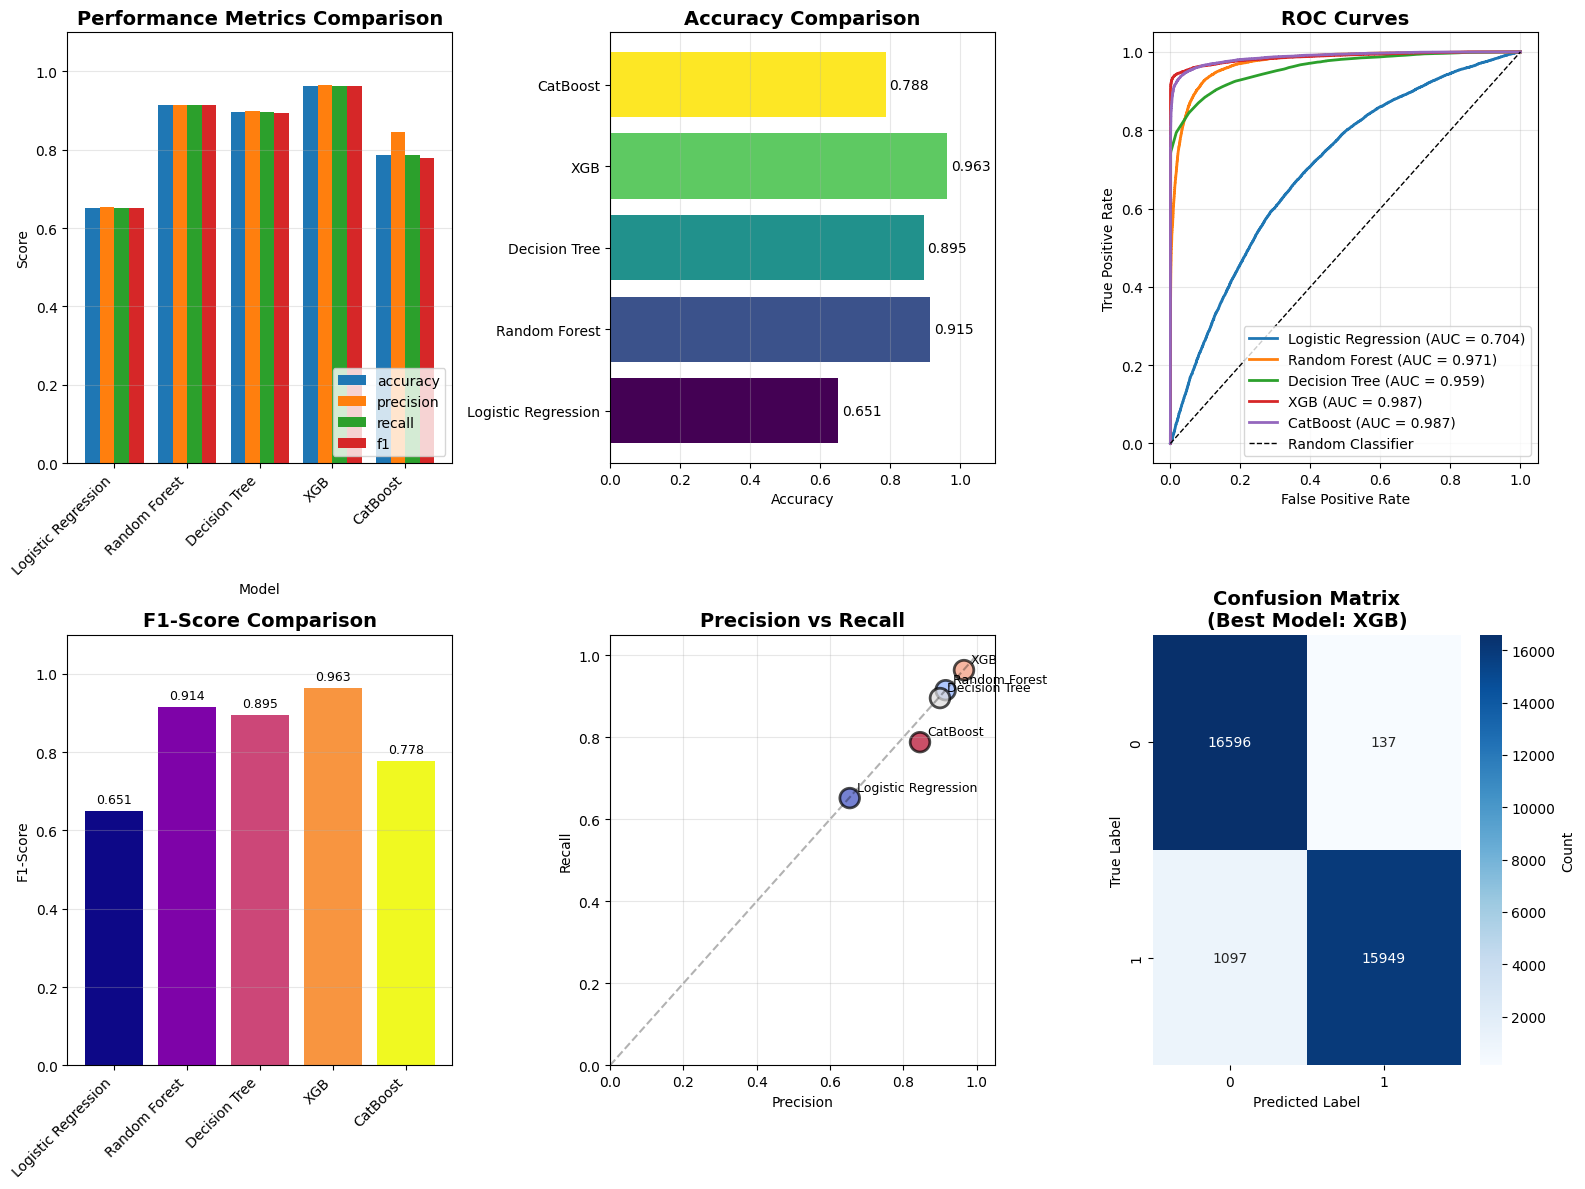

In [33]:
models = {
    'Logistic Regression': log_reg,
    'Random Forest': clf_rf,
    'Decision Tree': clf_dt, 
    'XGB': clf_xgb,
    'CatBoost': cat_model,
}

results, predictions = compare_models(X_test, y_test, models)



In [35]:
log_reg_opt = LogisticRegression(
    C=0.0004698660599370993,
    penalty='l2',
    solver='saga',
    max_iter=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

dt_opt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=29,
    min_samples_split=7,
    min_samples_leaf=6,
    max_features=None,
    class_weight=None,
    random_state=42
)

rf_opt = RandomForestClassifier(
    n_estimators=396,
    criterion='entropy',
    max_depth=31,
    min_samples_split=7,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

xgb_opt = xgb.XGBClassifier(
    n_estimators=279,
    max_depth=15,
    learning_rate=0.08149372019336734,
    subsample=0.772049662265316,
    colsample_bytree=0.8688411817644643,
    min_child_weight=1,
    gamma=3.1807321154178306e-05,
    reg_alpha=2.8859849941400407e-07,
    reg_lambda=0.0366816694677815,
    booster='gbtree',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

catboost_opt = CatBoostClassifier(
    iterations=440,
    depth=10,
    learning_rate=0.12954601614453032,
    l2_leaf_reg=2.0405380931054635,
    border_count=129,
    bagging_temperature=0.6695836288713665,
    random_strength=9.459320941234692,
    random_state=42,
    verbose=0
)

models = {
    'Logistic Regression': log_reg_opt,
    'Decision Tree': dt_opt,
    'Random Forest': rf_opt,
    'XGBoost': xgb_opt,
    'CatBoost': catboost_opt
}

# Train all models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

Training Logistic Regression...


C:\Users\Martin\Documents\X HEC\env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Training Decision Tree...
Training Random Forest...
Training XGBoost...


C:\Users\Martin\Documents\X HEC\env\lib\site-packages\xgboost\training.py:199: UserWarning:

[12:09:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




Training CatBoost...


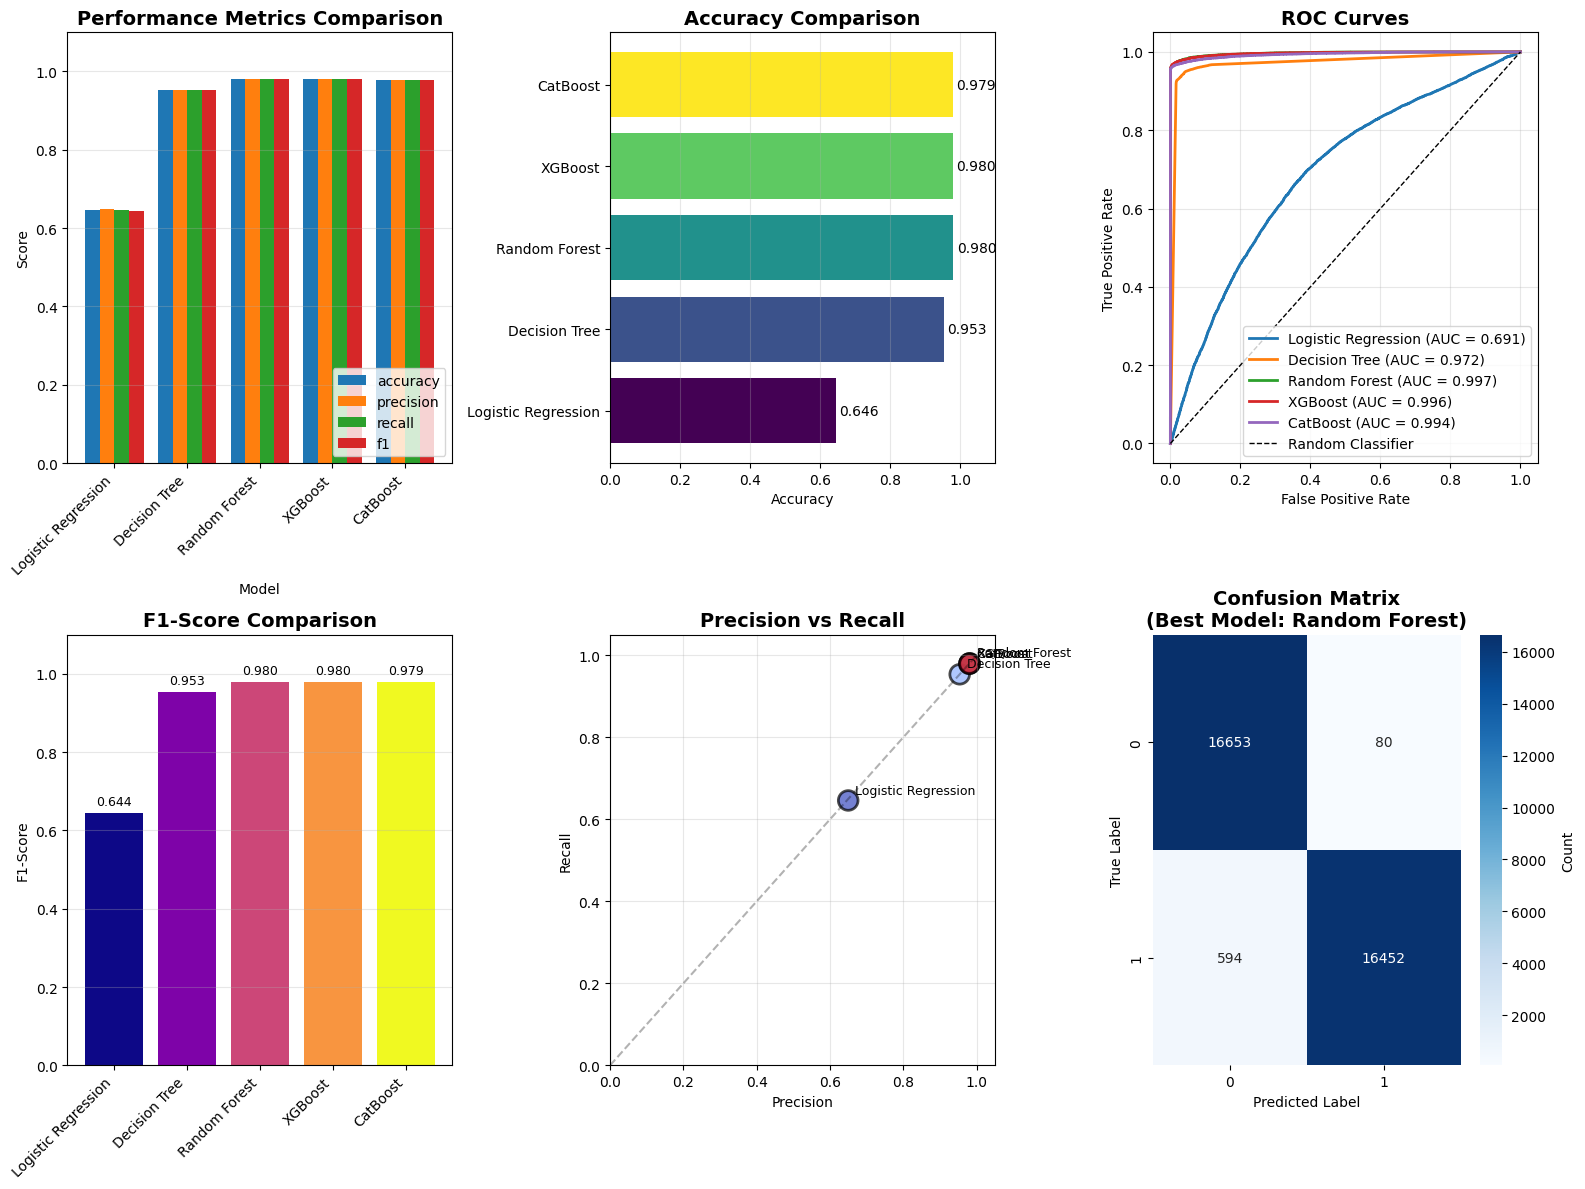

In [36]:
results, predictions = compare_models(X_test, y_test, models)


In [84]:
evaluate_model(log_reg_opt, test_submission, p=0.54, file_out="optimised_lr_opt.csv")
evaluate_model(dt_opt, test_submission, p=0.0001, file_out="optimised_dt_opt.csv")
evaluate_model(rf_opt, test_submission, p=0.12, file_out="optimised_rf_opt.csv")
evaluate_model(xgb_opt, test_submission, p=0.005, file_out="optimised_xgb_opt.csv")
evaluate_model(catboost_opt, test_submission, p=0.015, file_out="optimised_cat_opt.csv")

Base predicted churn: 60.26%
Predicted churn at 0.54 threshold: 50.31%
Submission saved to optimised_lr_opt.csv
Base predicted churn: 10.12%
Predicted churn at 0.0001 threshold: 25.96%
Submission saved to optimised_dt_opt.csv
Base predicted churn: 0.45%
Predicted churn at 0.12 threshold: 49.83%
Submission saved to optimised_rf_opt.csv
Base predicted churn: 0.76%
Predicted churn at 0.005 threshold: 51.93%
Submission saved to optimised_xgb_opt.csv
Base predicted churn: 0.79%
Predicted churn at 0.015 threshold: 53.41%
Submission saved to optimised_cat_opt.csv
